In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

%matplotlib inline

In [2]:
# Convolutional Neural Network
# keras functional API
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input,Layer,Lambda
from keras.layers import Flatten,BatchNormalization
from keras.layers import Dense,Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

# import tensorflow as tf
# tf.set_random_seed(1)

Using TensorFlow backend.


In [29]:
imhight = 128
imwidth = 128

# ALPHA = 0.2
ALPHA=100

# ネットワーク構造の定義
低層を共有

In [4]:
# shared Layer 
shared_Conv1= Conv2D(64, (4,4), padding='same', activation='relu')
shared_MP1= MaxPooling2D(pool_size=(2, 2))

### 最終的に埋め込みベクトルが欲しいのでSequentialで部分的にネットワークを定義しあとで使う
```
emb_vec = embNet.predict(a_in_test)
```

In [5]:
from keras import Sequential
def make_embNet():
    embNet = Sequential()
    embNet.add(Conv2D(64, (4,4) , padding='same', activation='relu',input_shape=(imhight,imwidth,3)))
    embNet.add(MaxPooling2D(pool_size=(2, 2)))
    embNet.add(BatchNormalization())
    embNet.add(Conv2D(64, (4,4) , padding='same', activation='relu'))
    embNet.add(MaxPooling2D(pool_size=(2, 2)))
    embNet.add(BatchNormalization())
    embNet.add(Conv2D(128, (4,4) , padding='same', activation='relu'))
    embNet.add(MaxPooling2D(pool_size=(2, 2)))
    embNet.add(BatchNormalization())
    embNet.add(Flatten()) # flatten before dense
    embNet.add(Dense(10, activation='relu'))
    return embNet

### with functional api

In [6]:
def create_embNet():
    some_input = Input(shape=(128, 128, 3))
    conv1 = shared_Conv1(some_input)
    pool1 = shared_MP1(conv1)
    conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    flatten = Flatten()(pool2)
    dense_layer = Dense(10, activation='relu')(flatten)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)
    return Model(inputs=[some_input], outputs=norm_layer)

In [7]:
# define three Inputs
a_in = Input(shape = (imhight, imwidth,3), name='anchor_input')
p_in = Input(shape = (imhight, imwidth,3), name='positive_input')
n_in = Input(shape = (imhight, imwidth,3), name='negative_input')

In [8]:
# for embedding
embNet_a = make_embNet()
embNet_p = make_embNet()
embNet_n = make_embNet()

a_emb = embNet_a(a_in)
p_emb = embNet_p(p_in)
n_emb = embNet_n(n_in)

In [9]:
# for embedding
embNet_a = create_embNet()
embNet_p = create_embNet()
embNet_n = create_embNet()

a_emb = embNet_a(a_in)
p_emb = embNet_p(p_in)
n_emb = embNet_n(n_in)

### Sequentialモデルを使わない場合は下記のコメントアウトを外す

In [10]:
# # anchor 
# a_in = Input(shape = (imhight, imwidth,3), name='anchor_input')
# conv1 = shared_Conv1(a_in)
# pool1 = shared_MP1(conv1)
# conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool1)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
# flatten = Flatten(name='anchor_output')(pool2)
# a_emb = Dense(1024, activation='relu')(flatten)

In [11]:
# # positive sample
# conv1 = Conv2D(64, (4,4), padding='same', activation='relu')(p_in)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
# # conv1 =  shared_Conv1(p_in)
# # pool1 = shared_MP1(conv1)
# conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool1)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
# flatten = Flatten(name='anchor_output')(pool2)
# a_emb = Dense(1024, activation='relu')(flatten)

In [12]:
# # negative sample
# conv1 = Conv2D(64, (4,4), padding='same', activation='relu')(n_in)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
# # conv1 =  shared_Conv1(n_in)
# # pool1 = shared_MP1(conv1)
# conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool1)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
# flatten = Flatten(name='anchor_output')(pool2)
# a_emb = Dense(1024, activation='relu')(flatten)

## triplet loss計算用のLayerインスタンスをLayerクラスを継承して作成
tensorflow --> numpy ×(error)<br>
numpy --> tensorflow ○<br>
triplet_lossの計算には **tensorflowの書式** を用いる。

In [13]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
    def get_config(self):
        config = {'alpha': self.alpha}
        base_config = super(TripletLossLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

・ numpy配列のリスト、**[a_emb,p_emb,n_emb]のtriplet**を入力とするレイヤーを定義<br>
・ LayerインスタンスとしてModelの中に組み込む<br>
・ Inputインスタンスを指定すると、emb(埋込)までを認識してくれる。

In [30]:
# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=ALPHA, name='triplet_loss_layer')([a_emb, p_emb, n_emb])

# Model that can be trained with anchor, positive negative images
tripletNet = Model([a_in, p_in, n_in], triplet_loss_layer)

## ネットワーク構造の可視化

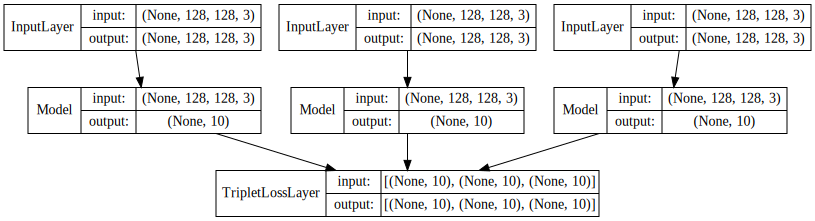

In [20]:
# 画像として出力
plot_model(tripletNet, show_shapes=True,  show_layer_names=False, to_file='./sup/tripletNetWithSequential.png')
# Jupyter上に構造を出力
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(tripletNet, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

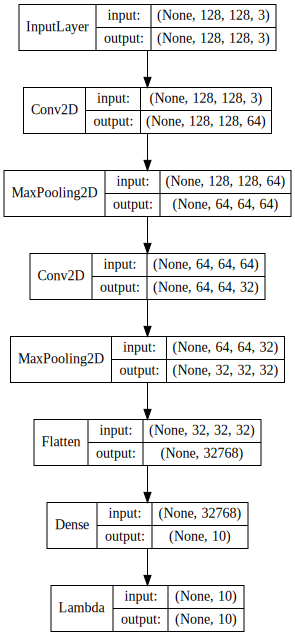

In [21]:
# plot embNet
plot_model(embNet_a, show_shapes=True,  show_layer_names=False, to_file='./sup/embNet.png')
SVG(model_to_dot(embNet_a, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

## --------------------------------------
## (確認済)動作確認

In [17]:
# sample data
# data_gen.pyからtriplet_generatorを読み込んでsample生成
from data_gen import triplet_generator
generator = triplet_generator()

### モデルのコンパイル

In [18]:
tripletNet.compile(loss=None, optimizer='adam')
# tripletNet.fit_generator(generator=generator, epochs=10, steps_per_epoch=100)

/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Output "triplet_loss_layer" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "triplet_loss_layer" during training.
  """Entry point for launching an IPython kernel.


In [19]:
import numpy as np
a_batch = np.random.rand(4, 128, 128, 3)
p_batch = np.random.rand(4, 128, 128, 3)
n_batch = np.random.rand(4, 128, 128, 3)

x = [a_batch,p_batch,n_batch]

In [20]:
# tripletNet=tripletNet.fit(x, epochs=1, steps_per_epoch=100)

In [21]:
np.array(x).shape

(3, 4, 128, 128, 3)

## 簡単なデータセットで実験してみる
いきなりDeepFashionのデータを扱うのではなく、より簡単な画像で実験する。<br>
<del>アニメのキャラ画像でやる。</del><br>
乃木坂の画像でやる。

## 乃木坂の画像をnumpy配列に変更。

In [22]:
import os
from keras.preprocessing.image import array_to_img, img_to_array, list_pictures, load_img # keras library for image to array

In [23]:
# check dataset
os.listdir('nogi_imgs/') 

['the_others', 'nishino', 'test', 'shiraishi', 'akimoto', 'ikuta', '.DS_Store']

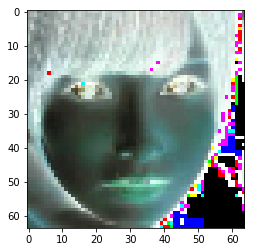

In [24]:
# load_imgを用いるとRGBがおかしくなる？
temp_img = load_img('./nogi_imgs/shiraishi/inputImage2_0.png', target_size=(64,64))
temp_img_array  = img_to_array(temp_img)
plt.imshow(temp_img_array)
plt.show()

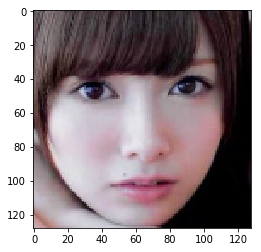

In [25]:
img = plt.imread('./nogi_imgs/shiraishi/inputImage2_0.png')
plt.imshow(img)
plt.show()

In [26]:
type(img)

numpy.ndarray

In [27]:
dir_path = './nogi_imgs/shiraishi/'
others_path = './nogi_imgs/akimoto/'
files = [f for f in sorted(os.listdir(dir_path))]
other_files = [o for o in sorted(os.listdir(others_path))]

同一人物の画像のペアを乱数で生成し、そこに別の人物の画像を加え**triplet**を構成する。<br>
**triplet = [anchor, positive, negative]**が想定されているのでそのようにリストを作成する。

In [28]:
# get anchor and positive image　
pair = np.random.randint(0,len(files),2)
anchor = Image.open('{0}{1}'.format(dir_path,files[pair[0]]))
positive = Image.open('{0}{1}'.format(dir_path,files[pair[1]]))

In [29]:
# get negative image
nega_idx = np.random.randint(len(other_files))
negative = Image.open('{}/{}'.format(others_path,other_files[nega_idx]))

In [30]:
type(anchor)

PIL.PngImagePlugin.PngImageFile

In [31]:
# get triplet
triplet = [anchor, positive, negative] 

## 可視化によるtripletの確認

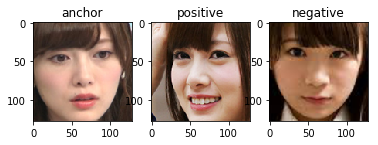

In [32]:
# method for visualization
def plot_triplet(triplet):
    title = ['anchor','positive','negative']
    for i,t in enumerate(triplet):
        plt.subplot(1,3,i+1)
        plt.imshow(triplet[i])
        plt.title('{}'.format(title[i]))
    plt.show()
    
plot_triplet(triplet)

## 各人xx個分のtripletを生成。

tripletが生成できていることが判ったため、大量に生成する。

In [33]:
# only name directories
names = [name for name in sorted(os.listdir('./nogi_imgs/'))]
names.remove('.DS_Store')
names.remove('test')
names.remove('the_others')

names

['akimoto', 'ikuta', 'nishino', 'shiraishi']

In [34]:
dir_pathes = []
for name in names:
    dir_pathes.append('./nogi_imgs/{}/'.format(name))

In [35]:
dir_pathes

['./nogi_imgs/akimoto/',
 './nogi_imgs/ikuta/',
 './nogi_imgs/nishino/',
 './nogi_imgs/shiraishi/']

In [36]:
triplet_num = 100
triplets = []
for i in range(len(dir_pathes)):
    # set the files of anchor and positive images
    anc_pos_files = [f for f in sorted(os.listdir(dir_pathes[i]))]
    anc_pos_files.remove('.DS_Store')
    for iteration in range(triplet_num):

        # set the files of negative images
        j = random.choice([num for num in range(len(dir_pathes)) if num not in [i]])
        nega_files = [o for o in sorted(os.listdir(dir_pathes[j]))]
        nega_files.remove('.DS_Store')

        # get anchor and positive images as numpy array
        pair = np.random.randint(0,len(anc_pos_files),2)
        anchor = np.array(Image.open('{0}{1}'.format(dir_pathes[i],anc_pos_files[pair[0]])).resize((imwidth,imhight)))
        positive = np.array(Image.open('{0}{1}'.format(dir_pathes[i],anc_pos_files[pair[1]])).resize((imwidth,imhight)))

        # get negative images as numpy array
        nega_idx = np.random.randint(len(nega_files))
        negative = np.array(Image.open('{0}{1}'.format(dir_pathes[j],nega_files[nega_idx])).resize((imwidth,imhight)))

        # make triplet
        triplet = [anchor, positive, negative]
        
        # (optional)visualization
        # plot_triplet(triplet)
        
        # append with normalization (0,1)
        triplets.append([anchor/255., positive/255., negative/255.])
        
# save triplets as numpy array
triplets = np.array(triplets)
print('save file')
np.save('./model/triplets.npy',triplets)

save file


## -----------------------------------------------------
## モデルのコンパイル及び学習(保存まで)

### loss = 0 means that " D(anchor,positive) - D(anchor,negative) = alpha(margin) "

In [31]:
# load triplets
triplets = np.load('./model/triplets.npy')

# compile model
tripletNet.compile(loss=None, optimizer='adam')

# fit model
# tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=10, steps_per_epoch=100)
tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=100, batch_size=50) # using batch_size is better
tripletNet.save('./model/triplet.h5')

# save partial Network 
embNet_a.save('./model/embNet_a.h5')
embNet_p.save('./model/embNet_p.h5')
embNet_n.save('./model/embNet_n.h5')

/home/inouelab/.conda/envs/keras35/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Output "triplet_loss_layer" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "triplet_loss_layer" during training.
  """


Epoch 1/100
400/400 [==============================] - 2s 5ms/step - loss: 4900.1480
Epoch 2/100
400/400 [==============================] - 2s 4ms/step - loss: 4900.0709
Epoch 3/100
400/400 [==============================] - 2s 4ms/step - loss: 4900.0211
Epoch 4/100
400/400 [==============================] - 2s 4ms/step - loss: 4900.0133
Epoch 5/100
400/400 [==============================] - 2s 4ms/step - loss: 4900.0044
Epoch 6/100
400/400 [==============================] - 2s 4ms/step - loss: 4900.0025
Epoch 7/100
400/400 [==============================] - 2s 4ms/step - loss: 4900.0012
Epoch 8/100
400/400 [==============================] - 2s 4ms/step - loss: 4900.0005
Epoch 9/100
400/400 [==============================] - 2s 4ms/step - loss: 4900.0002
Epoch 10/100
400/400 [==============================] - 2s 4ms/step - loss: 4900.0000
Epoch 11/100
400/400 [==============================] - 2s 4ms/step - loss: 4900.0000
Epoch 12/100
400/400 [==============================] - 2s 4ms/

400/400 [==============================] - 2s 4ms/step - loss: 4900.0000
Epoch 96/100
400/400 [==============================] - 2s 4ms/step - loss: 4900.0000
Epoch 97/100
400/400 [==============================] - 2s 4ms/step - loss: 4900.0000
Epoch 98/100
400/400 [==============================] - 2s 4ms/step - loss: 4900.0001
Epoch 99/100
400/400 [==============================] - 2s 4ms/step - loss: 4900.0010
Epoch 100/100
400/400 [==============================] - 2s 4ms/step - loss: 4900.0002


-----------以下 **emb4retrieval.ipynb** に引き継ぎ-----------
## model(別名)としてロードできるか確認
ロード対象は**embNet_a**

In [52]:
from keras.models import load_model
# model = load_model('./model/triplet.h5',custom_objects={'TripletLossLayer':TripletLossLayer})
model = load_model('./model/embNet_a.h5',custom_objects={'TripletLossLayer':TripletLossLayer})

/home/inouelab/anaconda3/envs/keras/lib/python3.5/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [44]:
tripletNet.save_weights("./model/triplet.hdf5")

In [45]:
model.load_weights("./model/triplet.hdf5")

## 学習に使っていないデータでpredictし出力の形を確認

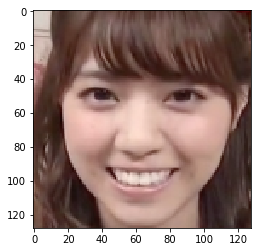

In [46]:
test_img = plt.imread('./nogi_imgs/test/inputImage_0.png')
plt.imshow(test_img)
plt.show()